In [1]:
%%capture
%run "C:\Users\Fredric\Documents\Volcano\quail_volcano\src\physics\multiphasevpT\inv_steam_tabulation.py"

This notebook works with 1D optimization (and looks at some KDtree lookups, which don't seem to offer too much). The outcome of this investigation is the creation of a 1D root finder based solver that iterates over pressure, and within each loop, iterates cheaply over temperature (which does not vary as much).

In [155]:
%%capture
%run "C:\Users\Fredric\Documents\Volcano\quail_volcano\src\physics\multiphasevpT\p_steam_root1d.py"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
print(f"{comp_count} computations.")
print(f"{1e3*seconds_per_comp} ms per computation.")

NameError: name 'comp_count' is not defined

In [157]:
p_out

array([[ 1.90423217,  0.        ,  3.73273855, ...,  0.        ,
                nan,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.83854534,  0.        ,  3.62811065, ...,  0.        ,
                nan,  0.        ],
       ...,
       [        nan,  0.        ,         nan, ...,  0.        ,
        98.94897176,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [        nan,  0.        ,         nan, ...,  0.        ,
        98.93045481,  0.        ]])

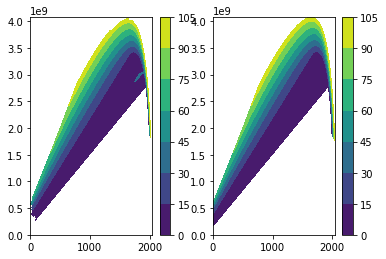

In [189]:
skip_filter = lambda z: z[range(0, arhoM.shape[0], 2),:][:, range(0, arhoM.shape[1], 2)]
plt.subplot(1,2,1)
plt.contourf(skip_filter(arhoM), skip_filter(e), skip_filter(p_out))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()

plt.subplot(1,2,2)
plt.contourf(skip_filter(arhoM), skip_filter(e), skip_filter(itab.rd_tab["p"]))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()

In [2]:
from inv_steam_tabulation import InverseTabulation

class Params():
    ''' Skinny version of physics, containing magma properties. '''
    Gas = [
        {"R": 287., "gamma": 1.4},
        {"R": 8.314/18.02e-3, "c_p": 2.288e3}]
    Liquid = {"K": 10e9, "rho0": 2.5e3, "p0": 5e6,
        "E_m0": 0, "c_m": 3e3}
    Solubility = {"k": 5e-6, "n": 0.5}
# Pick some test values
arhoW = 200.0
# Set up inverse tabulation for test case (near-exact solution from XSteam
# in the forward direction, although note that their method is iterative in
# the IAPWS region 3).
itab = InverseTabulation(Params(), is_required_regular_grid=True)
# Compute for chosen arhoW on redistributed mesh
arhoM, e = itab.get_arhoM_e_on_rd_sampling(arhoW)
volfracW = itab.get_mix_volfracWater_on_rd_sampling(arhoW)
# Compute for chosen arhoW on regular mesh
arhoM_reg, e_reg = itab.get_arhoM_e_on_reg_sampling(arhoW)
volfracW_reg = itab.get_mix_volfracWater_on_reg_sampling(arhoW)



In [4]:
itab.get_mix_volfracWater_on_reg_sampling(2000)

array([[  2.0116191 ,   2.01057922,   2.00954225, ...,   1.92179427,
          1.92096202,   1.92013128],
       [  2.013414  ,   2.01236811,   2.01132521, ...,   1.92330082,
          1.92246823,   1.92163721],
       [  2.01530682,   2.01425462,   2.01320549, ...,   1.92487518,
          1.92404191,   1.92321024],
       ...,
       [606.85184351, 302.89187618, 201.59513988, ...,   6.87654375,
          6.82350697,   6.77159604],
       [611.51052049, 305.22878012, 203.15742959, ...,   6.91849332,
          6.86495988,   6.81256397],
       [616.16185939, 307.56211059, 204.7174265 , ...,   6.96052953,
          6.90649853,   6.85361673]])

In [2]:
%load_ext autoreload
%autoreload 2

In [162]:
import importlib
importlib.reload(p_steam_root1d)

<module 'p_steam_root1d' from 'c:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\physics\\multiphasevpT\\p_steam_root1d.py'>

In [255]:
scalc.calls_inner, scalc.calls_outer , scalc.calls_inner / scalc.calls_outer

(2839644, 322192, 8.813514922778964)

In [249]:
t01 = perf_counter()
for i in range(100):
  stab.t_ph(p,h)
t02 = perf_counter()
(t02-t01)*1000/100

0.01035799999954179

In [266]:
from scipy import interpolate
f = interpolate.NearestNDInterpolator((itab.rd_tab["p"].ravel(), itab.rd_tab["h"].ravel()), itab.rd_tab["t_ph"].ravel(), rescale=True)

In [272]:
t01 = perf_counter()
for i in range(100):
  f((p,h))
t02 = perf_counter()
(t02-t01)*1000/100

0.03598999999667285

In [41]:
itab.rd_tab["t_ph"][33,0]
itab.steam_table.criticalTemperatur()

647.096

In [157]:
import p_steam_root1d
scalc = p_steam_root1d.SteamCalc(itab, Params.Liquid, method="bisect-newton")
p_out, T_out, rho_out = scalc.volfracCompatSolve1D(arhoW, arhoM[33,0], e[33,0])

In [141]:
'''Development of bisect-Newton method'''
from pyXSteam.XSteam import RegionSelection
import scipy.optimize

bisect1_atol = 1e2
newton_tol = 1e-5
# Simulate pressure
p = 0.1
# h(T) replacing v_pT with magma-constrained volume, consistent at the solution
h_estimate = lambda T: 1e-3*(e[1,1] - arhoM[1,1] * scalc.c_m * T) / arhoW \
    + 1e3*p*scalc.v_w_SI(1e6*p, arhoW, arhoM[1,1])
# T(h), inverse of the above
T_estimate = lambda h: (e[1,1] - arhoW * 1e3*(h 
  - 1e3*p*scalc.v_w_SI(1e6*p, arhoW, arhoM[1,1]))) \
  / (arhoM[1,1] * scalc.c_m)
# Energy equality
eq_h = lambda h: scalc.t_ph(p, h) \
  - (e[1,1] - arhoW * 1e3*(h - 1e3*p*scalc.v_w_SI(1e6*p, arhoW, arhoM[1,1]))) \
  / (arhoM[1,1] * scalc.c_m)
# Rough bisection
h, r1 = scipy.optimize.bisect(eq_h,
  100, 3600, xtol=bisect1_atol, full_output=True)
# Compute thermodynamically consistent T(h)
T_thermo = itab.steam_table.t_ph(p, h)

fcalls_misc = 1
fcalls_bisection_part_1 = r1.function_calls
fcalls_bisection_part_2 = 0
fcalls_newton = 0

while np.abs(T_estimate(h) - T_thermo) > newton_tol:
  # Select steam table region
  region = RegionSelection.region_ph(p, h)
  if region in {1,2}:
    c_p = itab.steam_table.Cp_ph(p, h)
    # Cp_pt is faster in region 1 and 2, but estimate of T may not be in region
    # c_p = itab.steam_table.Cp_pt(p, T_estimate(h))
  elif region == 3:
    c_p = itab.steam_table.Cp_ph(p, h)
  else:
    # Rebracket root
    h_low = h - (3600-100)/2**(r1.iterations+1)
    h_high = h + (3600-100)/2**(r1.iterations+1)
    # Perform bisection
    h, r2 = scipy.optimize.bisect(eq_h, h_low, h_high, xtol=1e2, full_output=True)
    fcalls_bisection_part_2 += r2.function_calls
    break
  # Take Newton step using c_p to compute slope
  dfdh = -arhoW / arhoM[1,1] / (scalc.c_m/1e3) - 1/c_p
  h -= (T_estimate(h) - T_thermo) / dfdh
  fcalls_newton += 2
  T_thermo = itab.steam_table.t_ph(p, h)
  
f_calls = (fcalls_misc, fcalls_bisection_part_1, fcalls_bisection_part_2, fcalls_newton)

h, T_estimate(h), T_thermo, f_calls
# (T_estimate(h), itab.steam_table.t_ph(p, h)), c_p, dT, h, hnew, (T_estimate(hnew), itab.steam_table.t_ph(p, hnew))

(247.61654822014432, 332.2929295326665, 332.29292991250094, (1, 8, 0, 4))

In [102]:
h, r = scipy.optimize.bisect(eq_h, 100, 3600, xtol=1e2)

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 6
           root: 264.0625

In [18]:
from time import perf_counter
import p_steam_root1d

scalc = p_steam_root1d.SteamCalc(itab, Params.Liquid)
# Compute values corresponding to feasible values on redistributed mesh
arhoW_vec = np.array(np.linspace(10,1000,6))
p_out = np.zeros((*arhoW_vec.shape, *arhoM.shape))
T_out = np.zeros((*arhoW_vec.shape, *arhoM.shape))
rho_out = np.zeros((*arhoW_vec.shape, *arhoM.shape))
comp_count = 0
t1 = perf_counter()
for m in range(0, p_out.shape[0],1):
  volfracW = itab.get_mix_volfracWater_on_rd_sampling(arhoW_vec[m])
  for i in range(0, p_out.shape[1],1):
    for j in range(0, p_out.shape[2],1):
      # If the state is in the feasible set
      if np.abs(volfracW[i,j]-0.5) <= 0.5:
        try:
          p_out[m,i,j], T_out[m,i,j], rho_out[m,i,j] = scalc.volfracCompatSolve1D(
            arhoW_vec[m], arhoM[i,j], e[i,j])
          comp_count += 1
        except:
          p_out[m,i,j] = np.nan
      else:
        p_out[m,i,j] = np.nan
t2 = perf_counter()
seconds_per_comp = (t2 - t1) / comp_count

print(f"{comp_count} computations.") # 24722
print(f"{1e3*seconds_per_comp} ms per computation.")

[-1214.5524668960425, -1101.4660259676111, -990.3610802321484, -882.607566471404, -780.7797577190745, -686.8029301973619, -600.082188713827, -513.4204448582486, -417.1865397909968, -305.2047450975099]
[-4330.1788890404, -4120.8424457263145, -4005.6606482312054, -3890.4788507360963, -3775.297053240987, -3660.115255745878, -3544.933458250769, -3208.6970989363226, -2881.8312800012995, -2568.0775931131298]
[736.786102165207, 805.7280267463266, 780.5153055084704, 755.3025842706141, 730.0898630327579, 704.8771417949017, 679.6644205570456, 875.506261138526, 1061.977561340584, 1235.3367294957889]
[230.82016091158206, 313.78129520519525, 302.58778367983274, 291.3942721544702, 280.20076062910766, 269.00724910374515, 257.81373757838264, 467.67478787235683, 668.1652977869085, 855.5436756546069]
[83.95414854119494, 170.98461884971204, 163.8604433392534, 156.73626782879478, 149.61209231833615, 142.4879168078775, 135.36374129741884, 349.294127606297, 553.8539735357524, 745.3016874183548]
[14.05312603

In [16]:
itab.rd_tab["h"][i,j]

1673.9729096274161

In [163]:
from time import perf_counter
scalc = p_steam_root1d.SteamCalc(itab, Params.Liquid, method="bisect-newton")
# Compute values corresponding to feasible values on redistributed mesh
p_out = np.zeros_like(arhoM)
T_out = np.zeros_like(arhoM)
rho_out = np.zeros_like(arhoM)
comp_count = 0
t1 = perf_counter()
for i in range(0, arhoM.shape[0],1):
  for j in range(0, arhoM.shape[1],1):
    # If the state is in the feasible set
    if np.abs(volfracW[i,j]-0.5) <= 0.5:
      p_out[i,j], T_out[i,j], rho_out[i,j] = scalc.volfracCompatSolve1D(arhoW, arhoM[i,j], e[i,j])
      comp_count += 1
    else:
      p_out[i,j] = np.nan
t2 = perf_counter()
seconds_per_comp = (t2 - t1) / comp_count

print(f"{comp_count} computations.") # 24722
print(f"{1e3*seconds_per_comp} ms per computation.")

function Cp_pt is not available in region 4 for input p 12.489767 and T 600.903056
Preasure outside valid area
Region switch t_ph returned unknown value 0 for input p 12.489767 and h nan
Preasure outside valid area
Region switch v_ph returned unknown value 0 for input p 12.489767 and h nan
function Cp_pt is not available in region 4 for input p 12.489767 and T 600.903056
Preasure outside valid area
Region switch t_ph returned unknown value 0 for input p 12.489767 and h nan
Preasure outside valid area
Region switch v_ph returned unknown value 0 for input p 12.489767 and h nan
Preasure outside valid area
Region switch t_ph returned unknown value 0 for input p 12.489767 and h nan
function Cp_pt is not available in region 4 for input p 12.492424 and T 600.919467
Preasure outside valid area
Region switch t_ph returned unknown value 0 for input p 12.492424 and h nan
Preasure outside valid area
Region switch v_ph returned unknown value 0 for input p 12.492424 and h nan
h3_pT stopped iterating

KeyboardInterrupt: 

In [165]:
i,j, arhoM.shape

(104, 29, (303, 100))

In [31]:
i, j = 0, 0
scalc.volfracCompatSolve1D(arhoW_vec[2], arhoM[i,j], e[i,j])

(nan, nan, nan)

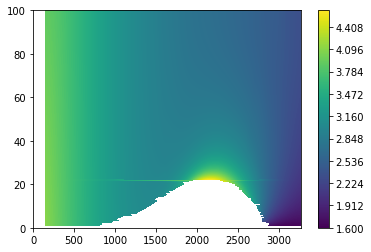

In [20]:
from pyXSteam.XSteam import RegionSelection
# Compute values corresponding to feasible values on redistributed mesh
c_v_compute = np.ones_like(arhoM)*np.nan
comp_count = 0
for i in range(0, arhoM.shape[0]):
  for j in range(0, arhoM.shape[1]):
    region = RegionSelection.region_ph(itab.rd_tab["p"][i,j], itab.rd_tab["h"][i,j])
    if region != 4:
      c_v_compute[i,j] = itab.steam_table.Cv_ph(itab.rd_tab["p"][i,j], itab.rd_tab["h"][i,j])
plt.contourf(itab.rd_tab["h"], itab.rd_tab["p"], c_v_compute, levels=400)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()

c:\Python39\lib\site-packages\matplotlib\contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
c:\Python39\lib\site-packages\matplotlib\contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


True

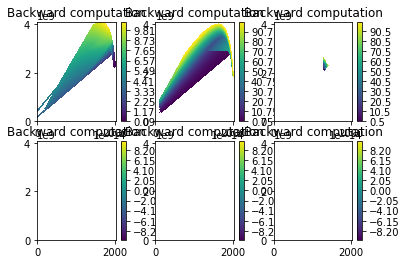

In [23]:

for i in range(len(arhoW_vec)):
  plt.subplot(2,3,i+1)
  plt.contourf(arhoM, e, p_out[i,...], levels=400)
  plt.xlim(left=0)
  plt.ylim(bottom=0)
  plt.colorbar()
  plt.title("Backward computation")
np.all(np.isnan(p_out[-1,...]))

Text(0.5, 1.0, 'Steam table forward computation')

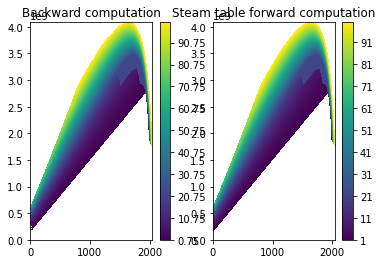

In [26]:
plt.subplot(1,2,1)
plt.contourf(arhoM, e, p_out, levels=400)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()
plt.title("Backward computation")

plt.subplot(1,2,2)
plt.contourf(arhoM, e, itab.rd_tab["p"], levels=400)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()
plt.title("Steam table forward computation")

In [257]:
pPick, TPick, rhoPick = scalc.volfracCompatSolve1D(arhoW, arhoM[1,1], e[1,1])
dpdrho_s = itab.steam_table.w_pt(pPick,TPick)**2
print(f"Point in high arhoM: for 1 kg/m^3 isentropic change in density: {dpdrho_s/1e6} MPa change.")
print(f"Point in high arhoM: density: {rhoPick} kg/m^3.")
print(f"Point in high arhoM: inverse isentropic compressibility: {rhoPick*dpdrho_s/1e6} MPa or {rhoPick*dpdrho_s/1e8} MPa/%")
print(f"p {pPick}; tabulated {itab.rd_tab['p'][1,1]}")

Point in high arhoM: for 1 kg/m^3 isentropic change in density: 2.4201617215929443 MPa change.
Point in high arhoM: density: 984.2452399902111 kg/m^3.
Point in high arhoM: inverse isentropic compressibility: 2382.0326544843697 MPa or 23.8203265448437 MPa/%
p 1.479101064923904; tabulated 1.4787272727272727


In [216]:
stab = itab.steam_table
p, T, rho = scalc.volfracCompatSolve1D(arhoW, arhoM[1,1], e[1,1])
h, rho = scalc.hrho_brent_ph(p, (32,4000), arhoW, arhoM[1,1], e[1,1])
# Compared pressures
p, itab.rd_tab["p"][1,1]

(1.4789734684788136, 1.4787272727272727)

In [219]:
# Saturation condition (scalc-method)
# scalc.saturation_condition_p(itab.rd_tab["p"][1,1], arhoW, arhoM[1,1],
      # e[1,1], xtol=1e-3)
# scalc.compute_rho_T(p, arhoW, arhoM[1,1], e[1,1], is_T_needed=True)
itab.rd_tab["rho_ph"][1,1], stab.rho_ph(itab.rd_tab["p"][1,1], itab.rd_tab["h"][1,1]), \
      1/scalc.v_w_SI(1e6*itab.rd_tab["p"][1,1], arhoW, arhoM[1,1])

(984.2452774846487, 984.2452774846487, 984.2452774846488)

In [208]:
# Energy condition (scaled to O(rho * c_m * T))
e[1,1] - arhoW * 1e3 * stab.u_pt(p,T) - arhoM[1,1] * scalc.c_m * T, \
  e[1,1] - arhoW * 1e3 * itab.rd_tab["u_ph"][1,1] - arhoM[1,1] * scalc.c_m * itab.rd_tab["t_ph"][1,1],

(-2661.521834373474, 2.384185791015625e-07)

In [224]:
# Alt energy condition (scaled to O(T) )
stab.t_ph(p, h) - (e[1,1] - arhoW * 1e3*stab.u_ph(p,h)) \
      / (arhoM[1,1] * scalc.c_m)

3.0127011996228248e-12

In [226]:
# Confidence metric: difference in steam table density and magma-constrained density of water

# Volume constraint consistency
consistency_volconstr = lambda p, T: (stab.rho_pt(p, T) - 1.0 / scalc.v_w_SI(1e6*p, arhoW, arhoM[1,1]))
# p, h, T consistency
consistency_phT = lambda p, h, T: stab.rho_ph(p, h) - stab.rho_pt(p, T)
# dp per relative density change (MPa)
rho_dp_drho = lambda p, T: 1e-6 * stab.w_pt(p, T)**2
# Estimated dp confidence
dp_conf = lambda p, h, T: (np.abs(consistency_volconstr(p, T)) + \
  np.abs(consistency_phT(p, h, T))) * rho_dp_drho(p,T)

consistency_volconstr(itab.rd_tab["p"][1,1], itab.rd_tab["t_ph"][1,1]), \
  consistency_phT(itab.rd_tab["p"][1,1], itab.rd_tab["h"][1,1], itab.rd_tab["t_ph"][1,1]), \
  consistency_volconstr(p, T), \
  consistency_phT(p, h, T),

# dp = 1e-6 * stab.w_pt(pPick,TPick)**2 * (stab.rho_pt(p, T) - 1.0 / scalc.v_w(p, arhoW, arhoM[1,1]))
# dp, p - itab.rd_tab["p"][1,1]

(-1.1368683772161603e-13, 0.0, 2.4467458388244268e-06, 0.00019892601778792596)

In [227]:
dp_conf(p,h,T), dp_conf(itab.rd_tab["p"][1,1], itab.rd_tab["h"][1,1], itab.rd_tab["t_ph"][1,1])

(0.000487354517288059, 2.7514021614261705e-13)

Text(0.5, 1.0, 'Steam table forward computation')

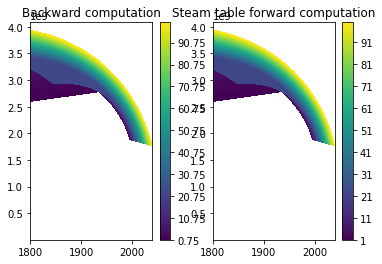

In [230]:
plt.subplot(1,2,1)
plt.contourf(arhoM, e, p_out, levels=400)
plt.xlim(left=1800)
plt.ylim(bottom=1.5)
plt.colorbar()
plt.title("Backward computation")

plt.subplot(1,2,2)
plt.contourf(arhoM, e, itab.rd_tab["p"], levels=400)
plt.xlim(left=1800)
plt.ylim(bottom=1.5)
plt.colorbar()
plt.title("Steam table forward computation")

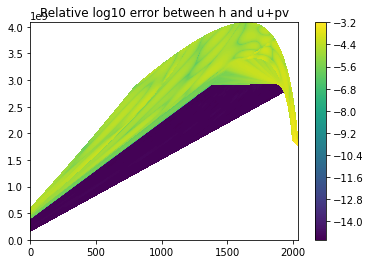

In [232]:
# Error quantification in h - (u + pv)
q_h = itab.rd_tab["h"]
q_upv = itab.rd_tab["u_ph"] + 1e3 * itab.rd_tab["p"] * itab.rd_tab["v_ph"]
err_rel = q_upv/q_h - 1.0
log_rel = np.log10(np.abs(q_upv/q_h - 1.0) + 1e-15)
plt.contourf(arhoM, e, log_rel, levels=600)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.title("Relative log10 error between h and u+pv")
cb = plt.colorbar()

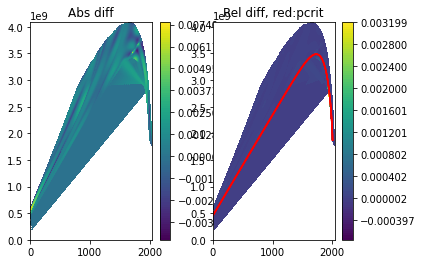

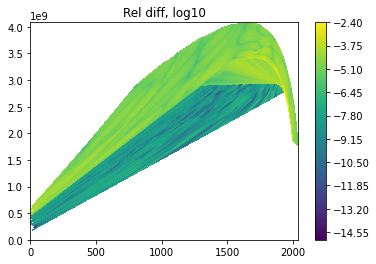

In [240]:
# Compute differences
pdiffs = (p_out - itab.rd_tab["p"])
indices_physical = np.where(np.logical_and.reduce((
  arhoM>=0,e>=0,np.isfinite(pdiffs))))
pdiffs_physical = pdiffs[indices_physical]
levels_abs = np.linspace(np.min(pdiffs_physical), np.max(pdiffs_physical), 100)

pdiffs_physical_rel = pdiffs_physical / itab.rd_tab["p"][indices_physical]
levels_rel = np.linspace(np.min(pdiffs_physical_rel), np.max(pdiffs_physical_rel), 100)

plt.subplot(1,2,1)
plt.contourf(arhoM, e, pdiffs, levels_abs)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()
plt.title("Abs diff")

plt.subplot(1,2,2)
plt.contourf(arhoM, e, p_out/itab.rd_tab["p"] - 1.0, levels_rel)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()
plt.contour(arhoM, e, itab.rd_tab["p"] > itab.p_crit, 1, colors='red')
plt.contour(arhoM, e, itab.rd_tab["p"] > itab.p_crit, 1, colors='red')
plt.title("Rel diff, red:pcrit")

plt.figure()
logfilter = lambda z: np.log10(np.abs(z) + 1e-15)
plt.contourf(arhoM, e, logfilter(p_out/itab.rd_tab["p"] - 1.0), levels=100)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.colorbar()
plt.title("Rel diff, log10")
pass

In [98]:
from time import perf_counter


steam_table = itab.steam_table

def test_optim2D(arhoW, arhoM, e):
    def create_functions(variables, other_states):
        (pressure, enthalpy) = variables
        (arhoWv_val, arhoM_val, e_val, mom_val) = other_states

        # volume fraction of water vapor
        alpha_w = (Params.Liquid["p0"] - Params.Liquid["K"] - 1e6 * pressure +
                    (Params.Liquid["K"] / Params.Liquid["rho0"]) * arhoM_val) / \
                    (Params.Liquid["p0"] - Params.Liquid["K"] - 1e6 * pressure)
        internal_energy_magma = arhoM_val * Params.Liquid["c_m"] * 1e-3 * steam_table.t_ph(pressure, enthalpy)

        # if np.isnan(steam_table.u_pt(pressure, temperature)) or np.isnan(steam_table.h_pt(pressure, temperature)):
        #     # optimize over x_frac and pressure --> extract pressure and temperature
        #     print("Hello")

        # eqn for energy conservation
        eqn_1 = (mom_val ** 2 / (2 * (arhoM_val + arhoWv_val))) * 1e-3 \
                + arhoWv_val * steam_table.u_ph(pressure,
                                                enthalpy) + internal_energy_magma - e_val * 1e-3

        # eqn of state relating enthalpy, pressure, and energy
        eqn_2 = -enthalpy + steam_table.u_ph(pressure, enthalpy) \
                + (pressure * 1e3 * alpha_w) / arhoWv_val
        return np.array([eqn_1, eqn_2/1e4]).ravel()

    ub = (100., 3850.)  # upper bound: (pressure, enthalpy)
    lb = (0.000611213, 400.)  # lower bound -- 611.213 Pa (the lb for pressure) is in IAPWS documentation for lowest pressure
    solution = np.zeros(shape=(1, 7), dtype=float)

    x0 = (1., 600.)
    other_variables = (arhoW, arhoM, e, 0)
    solution_val = scipy.optimize.least_squares(lambda variables: create_functions(variables, other_variables),
                                                x0, bounds=(lb, ub), ftol=1e-8, xtol=1e-8, gtol=1e-8)
    p_optim2D = solution_val["x"][0] * 1e6  # pressure
    h_optim2D = solution_val["x"][1]  # enthalpy
    return p_optim2D, h_optim2D, solution_val

t1 = perf_counter()
num_runs2D = 1
for i in range(num_runs2D):
    p_2D, h_2D, soln = test_optim2D(arhoW, arhoM.copy()[0,0], e.copy()[0,0])
t2 = perf_counter()
print(f"{(t2-t1)*1e3/num_runs2D} ms per")
p_2D/1e6, itab.rd_tab["p"][0,0]
soln
# itab.rd_tab["p"][0,0]

6.209399998624576 ms per


 active_mask: array([ 1, -1])
        cost: 37830722740.21368
         fun: array([2.75066257e+05, 5.94457101e-04])
        grad: array([-3.74123633e+08,  4.63543869e+08])
         jac: array([[-1.36012188e+03,  1.68520805e+03],
       [ 1.50825682e-05, -1.38805008e-06]])
     message: 'Both `ftol` and `xtol` termination conditions are satisfied.'
        nfev: 8
        njev: 8
  optimality: 2.6349418301667496e-05
      status: 4
     success: True
           x: array([100., 400.])

In [2]:
# (arhoM, e) -> itab.rd_tab["p"]
arhoW = 200.0
arhoM, e = itab.get_arhoM_e_on_rd_sampling(arhoW)
x = arhoM.ravel()
y = e.ravel()
z = itab.rd_tab["p"].ravel()

In [39]:
import numpy as np
from scipy.spatial import KDTree

def kdtquery(x, y, qpoints):
  kdt = KDTree(np.vstack((x/1e3, y/1e9)).T)
  _, i = kdt.query(np.array(qpoints)*[1e-3,1e-9], k=1)
  return x[i], y[i]
qpoints = (1.5e3, 2.5e9)
nearest = kdtquery(x, y, qpoints)

qpoints, nearest

((1500.0, 2500000000.0), (2499.0, 2497895462.4451723))

In [60]:
%matplotlib tk
import matplotlib.pyplot as plt

def plot_temp(arhoW, quant="t_ph"):
  arhoM, e = itab.get_arhoM_e_on_rd_sampling(arhoW)
  plt.contourf(arhoM, e, itab.rd_tab[quant])
  # plt.scatter(arhoM, e, s=0.1, c='k')
  plt.xlim([0, 2525])
  plt.ylim([0, 8e9])
  if quant == "t_ph":
    plt.clim([200, 1000])
  elif quant == "p":
    plt.clim([0, 100])
  plt.colorbar()

arhoW_vec = [0.0, 0.1, 2.0, 5.0, 10.0, 20.0, 50.0, 1e2, 1e3]
plt.figure(1)
for i, arhoW in enumerate(arhoW_vec):
  plt.subplot(3,3,i+1)
  plot_temp(arhoW)
  plt.title(f"arhoW = {arhoW}")

plt.figure(3)
for i, arhoW in enumerate(arhoW_vec):
  plt.subplot(3,3,i+1)
  plot_temp(arhoW, quant="p")
  plt.title(f"arhoW = {arhoW}")

In [51]:
itab.get_arhoM_e_on_rd_sampling(1000)[0] - itab.get_arhoM_e_on_rd_sampling(0)[0]

array([[  -2335.30454417,   -2397.32600108,   -2428.72202103, ...,
          -2427.22021137,   -2425.87164775,   -2424.52524717],
       [  -2505.49514082,   -2516.35242557,   -2519.89448438, ...,
          -2429.10537297,   -2427.75919355,   -2426.41535043],
       [  -2599.83532062,   -2593.03716317,   -2586.47205586, ...,
          -2430.9613793 ,   -2429.61414862,   -2428.26940763],
       ...,
       [-657270.74837055, -446096.0333717 , -337509.65039099, ...,
          -8747.88331933,   -8644.87081208,   -8545.24258545],
       [-713979.10668612, -483408.51595683, -365275.94045543, ...,
          -8801.42244385,   -8697.35116408,   -8596.6842725 ],
       [-769918.84696137, -520257.23733908, -392721.60298663, ...,
          -8855.09341783,   -8749.96020915,   -8648.25079359]])

In [80]:
# Magma temperature estimate
plt.figure(4)
arhoM, e = itab.get_arhoM_e_on_rd_sampling(200)
plt.subplot(1,3,1)
plt.contourf(arhoM, e, itab.rd_tab["t_ph"], np.linspace(0,1000,20))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.clim([0, 1000])
plt.colorbar()
plt.title("Exact")
plt.subplot(1,3,2)
plt.contourf(arhoM, e, e/(3e3*arhoM), np.linspace(0,2000,20))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.clim([0, 1000])
plt.colorbar()
plt.title("Magma temperature estimate")
plt.subplot(1,3,3)
plt.contourf(arhoM, e, 1 - e/(3e3*arhoM)/itab.rd_tab["t_ph"], np.linspace(-1,1,30))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.clim([-1, 1])
plt.colorbar()
plt.title("Diff")

Text(0.5, 1.0, 'Diff')

In [116]:
''' Temperature estimator and iterative correction
When the magma mass fraction is sufficiently large, the heat capacity is
primarily provided by the dense magma. An affine approximation to the energy
density, using a nominal water heat capacity, can provide a good initial
estimate of the mixture temperature.
'''
cv_water_nominal = 1e3*itab.steam_table.Cv_ph(20, 3000)
e_water_crit = 1e3*itab.steam_table.u_pt(itab.p_crit, itab.T_crit)
e_water_est = lambda T: e_water_crit + cv_water_nominal * T
c_m = 3e3

# Magma temperature estimate
plt.figure(4)
arhoW_test = 20
arhoM, e = itab.get_arhoM_e_on_rd_sampling(arhoW_test)
plt.subplot(1,3,1)
plt.contourf(arhoM, e, itab.rd_tab["t_ph"], np.linspace(0,1000,20))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.clim([0, 1000])
plt.colorbar()
plt.title("Exact")
plt.subplot(1,3,2)
plt.contourf(arhoM, e, affine_T(arhoW_test, arhoM, e), np.linspace(0,1000,20))
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.clim([0, 1000])
plt.colorbar()
plt.title("Magma temperature estimate")
plt.subplot(1,3,3)
plt.contourf(arhoM, e, 1 - affine_T(arhoW_test, arhoM, e)/itab.rd_tab["t_ph"], np.linspace(-0.2,0.2,300))
plt.xlim(left=0)
plt.ylim(bottom=0)
# plt.clim([-1, 1])
plt.colorbar()
plt.title("RelDiff")

Text(0.5, 1.0, 'RelDiff')

In [3]:
arhoW = 200
arhoM, e = itab.get_arhoM_e_on_rd_sampling(arhoW)
arhoM_test = arhoM[50,50]
e_test = e[50,50]
p_test = itab.rd_tab["p"][50,50]
T_test = itab.rd_tab["t_ph"][50,50]
h_test = itab.steam_table.h_pt(p_test, T_test)
K = 10e9
p0 = 5e6
rho0 = 2.5e3
c_m = 3e3
cv_water_nominal = 1e3*itab.steam_table.Cv_ph(20, 3000)
e_water_crit = 1e3*itab.steam_table.u_pt(itab.p_crit, itab.T_crit)

In [162]:
# Fix pressure
p_guess = 30
K = 10e9
p0 = 5e6
rho0 = 2.5e3

print(p_test > itab.p_crit)
# Estimate temperature
T_est = (e_test - arhoW * (e_water_crit - cv_water_nominal * itab.T_crit)) \
  / (arhoM_test * c_m + arhoW * cv_water_nominal)
# Refine temperature at fixed pressure
fpi_T = lambda T: (e_test - arhoW * itab.steam_table.u_pt(p_test, T)) \
  / (arhoM_test * c_m)
T_refine = fpi_T(fpi_T(T_est))

fpi_p = lambda p: (K / rho0 * arhoM_test / (
  1.0 - arhoW / itab.steam_table.rho_pt(p, T_refine)) + p0 - K) / 1e6
print(fpi_p(fpi_p(p_guess)))

True
-1.2661881229381562


In [217]:
%matplotlib tk
plt.figure(101)
# Contour
# plt.contourf(itab.rd_tab["v_ph"], itab.rd_tab["t_ph"], itab.rd_tab["h"])
plt.contourf(itab.rd_tab["h"], itab.rd_tab["p"], np.log10(itab.rd_tab["v_ph"]))
# plt.scatter(itab.rd_tab["v_ph"], itab.rd_tab["t_ph"], s=0.1, c='r')

# 3D
# ax = plt.axes(projection='3d')
# ax.plot3D(itab.rd_tab["v_ph"].ravel(),
  # itab.rd_tab["t_ph"].ravel(),
  # itab.rd_tab["p"].ravel(), marker='.', color='k')

In [22]:
import scipy.optimize

def brent_T(p, Tlims, e_int, arhoW, arhoM, itab):
  # Equation giving T
  eq_T = lambda p, T: T - (e_int - arhoW * 1e3*itab.steam_table.u_pt(p, T)) \
    / (arhoM * c_m)
  if eq_T(p, Tlims[0]) * eq_T(p, Tlims[1]) > 0:
    T = np.nan
    rho = np.nan
  else:
    T = scipy.optimize.brentq(
      lambda T: eq_T(p, T), Tlims[0], Tlims[1])
    rho = itab.steam_table.rho_pt(p, T)
  return T, rho

def vol_p(p, arhoW, arhoM, e_int, itab):
  ''' Compute summed volume fraction at a pressure iterate p '''
  
  # Preprocess conservative state
  rho_mix = arhoM + arhoW
  yM = arhoM / rho_mix
  yW = arhoW / rho_mix
  # Magma constitutive equation
  rho_m = lambda p: rho0 * (1 + (p - p0)/ K)
  v_m = lambda p : K / (rho0 * (K + p - p0))
  # Specific volume of water constrained by magma volume
  v_w = lambda p: (1.0 / rho_mix - yM * v_m(p)) / yW
  
  def fpi_T(p, T_est):
    # Since T is relatively insensitive to pressure at fixed energy, only
    # several fixed point iterations should be needed.
    fpi_T = lambda T: (e_int - arhoW * 1e3*itab.steam_table.u_pt(p, T)) \
        / (arhoM * c_m)
    T = T_est
    for i in range(10):
      T_est = T
      T = fpi_T(T)
      if np.abs(T-T_est) < 1e-6:
        break
      if i >= 9:
        print("many iterations")
    return T

  def brent_T(p, Tlims):
    # Equation giving T
    eq_T = lambda p, T: T - (e_int - arhoW * 1e3*itab.steam_table.u_pt(p, T)) \
      / (arhoM * c_m)
    if eq_T(p, Tlims[0]) * eq_T(p, Tlims[1]) > 0:
      T = np.nan
      rho = np.nan
    else:
      T = scipy.optimize.brentq(
        lambda T: eq_T(p, T), Tlims[0], Tlims[1],
        xtol=1e-3)
      rho = itab.steam_table.rho_pt(p, T)
    return T, rho

  def compute_T_rho(p):
    use_fpi = False
    if p >= itab.steam_table.criticalPressure():
      ''' Fixed point iteration '''
      if use_fpi:
        # Set initial temperature guess using linearized supercritical representation.    
        T_est = (e_int - arhoW * (e_water_crit - cv_water_nominal * itab.T_crit)) \
          / (arhoM * c_m + arhoW * cv_water_nominal)
        # Check validity
        pass
        # Refine temperature estimate at fixed pressure by fixed point iteration
        T = fpi_T(p, T_est)
        rho = itab.steam_table.rho_pt(p, T)
      else:
        ''' Bisection-hybrid '''
        T, rho = brent_T(p, (274.0, 1000))
      # print("C")
    else:
      # Subcritical water may be in a vapour-liquid mixture. We use specific
      # energy to differentiate phase.
      # Check for two-phase system
      uL = itab.steam_table.uL_p(p)
      uV = itab.steam_table.uV_p(p)
      T_sat = itab.steam_table.tsat_p(p)
      # Compute available energy at saturation in kJ/kg
      uavail = 1e-3 * (e_int - arhoM * c_m * T_sat) / arhoW

      if uavail <= uL:
        # Water is less energetic than saturated liquid: condensed phase calc
        # T = compute_T(p, T_sat - 1.0)
        # Set bracketing values for T
        Tlims = (274, T_sat-0.1)
        T, rho = brent_T(p, Tlims)
        # print("L")
      elif uavail >= uV:
        # Water is more energetic than saturated vapour: vapour phase calc
        # T = compute_T(p, T_sat + 1.0)
        # Set bracketing values for T
        Tlims = (T_sat+0.1, 1000)
        T, rho = brent_T(p, Tlims)
        # print("V")
      else:
        # Water is mixture of liquid and vapour
        T = T_sat
        # Phase fraction decomposition
        yv = (uavail - uL) / (uV - uL)
        yl = 1.0 - yv
        v = yl * itab.steam_table.vL_p(p) + yv * itab.steam_table.vV_p(p)
        rho = 1.0 / v
        # print("LV")
    # print(p, T, rho)
    return T, rho
  
  # Fix magma volume fraction (satisfy magma mass equation, magma EOS)
  alphaM = arhoM / rho_m(p)
  # Compute temperature (satisfy energy equation, both EOS)
  T, rho = compute_T_rho(p)
  # Fix water volume fraction (satisfy water mass equation, water EOS)
  alphaW = arhoW / rho
  # Compute compatibility function (want == 0 to satisfy saturation)
  return alphaM + alphaW - 1.0

In [23]:
import scipy.optimize

def volfracCompatSolve1D(arhoW, arhoM, e, itab):
  f = lambda p: vol_p(p, arhoW, arhoM, e, itab)
  # Set limits to pressure due to steam tables
  plim = (0.1, 100)
  if f(plim[0]) * f(plim[1]) > 0:
    return np.nan
  return scipy.optimize.brentq(lambda p: vol_p(p, arhoW, arhoM, e, itab), .1, 100, xtol=1e-3)

In [127]:
arhoW * 1e3*itab.steam_table.u_pt(itab.rd_tab["p"][0,0], itab.rd_tab["t_ph"][0,0]) \
  + arhoM[0,0] * c_m * itab.rd_tab["t_ph"][0,0]
check_e = lambda e, arhoW, arhoM, p, T: \
  1 - (arhoW * 1e3*itab.steam_table.u_pt(p, T) \
  + arhoM * c_m * T) / e
check_e(e[0,0], arhoW, arhoM[0,0], itab.rd_tab["p"][0,0], itab.rd_tab["t_ph"][0,0])

0.0

In [130]:
alpha_W = arhoW / itab.steam_table.rho_pt(itab.rd_tab["p"][0,0], itab.rd_tab["t_ph"][0,0])

In [131]:
rho_m = lambda p: rho0 * (1 + (p - p0)/ K)
alpha_M = arhoM[0,0] / rho_m(1e6*itab.rd_tab["p"][0,0])

In [13]:
1e-3 * (itab.rd_tab["h"][0,0] - itab.rd_tab["u_ph"][0,0]) / itab.rd_tab["p"][0,0], \
  itab.rd_tab["v_ph"][0,0], \
  1/itab.steam_table.rho_ph(itab.rd_tab["p"][0,0], itab.rd_tab["h"][0,0]), \
  itab.steam_table.v_ph(itab.rd_tab["p"][0,0], itab.rd_tab["h"][0,0])

(0.0009344956159133915,
 0.0010058095493278758,
 0.0010058095493278758,
 0.0010058095493278758)

In [322]:
from time import perf_counter
import scipy.optimize

p_U = 7.701538
T_U = itab.T_crit - 1

fpi_T = lambda T: (e[0,0] - arhoW * 1e3*itab.steam_table.u_pt(p_U, T)) \
    / (arhoM[0,0] * c_m)
T = T_U
# for i in range(10):
  # T_est = T
  # T = fpi_T(T)
  # print(T)
T_test_vec = np.linspace(230,itab.T_crit-1,20)
# out_vec = np.array(list(map(lambda T:fpi_T(fpi_T(T)),  T_test_vec)))
# plt.plot(T_test_vec, out_vec, '.-')

t1 = perf_counter()
for i in range(100):
  scipy.optimize.brentq(lambda T: T - (e[0,0] - arhoW * 1e3*itab.steam_table.u_pt(p_U, T)) \
      / (arhoM[0,0] * c_m), 280, itab.T_crit)
perf_counter()-t1

0.024877800002286676

In [313]:
import scipy.interpolate
# Produce melting temperature curve (cheap)
N_T_samples = 5
t_range = np.linspace(273.157,255,N_T_samples)
p_melt_range = np.array(list(map(lambda T: itab.steam_table.pmelt_t(T, itab.steam_table.TYPE_ICE_Ih), t_range)))
T_melt = scipy.interpolate.interp1d(p_melt_range, t_range, kind='cubic')
print(p_melt_range)
# Testing T_melt: p -> T
p_test_range = np.linspace(0.1,10,100)

# Equation for temperature
eq_T = lambda p, T: T - (e[0,0] - arhoW * 1e3*itab.steam_table.u_pt(p, T)) \
  / (arhoM[0,0] * c_m)
# scipy.optimize.brentq(eq_T, 274, itab.steam_table.tsat_p(p_U-1e-3))

[4.10049306e-02 5.48894755e+01 1.01245665e+02 1.42235090e+02
 1.79413418e+02]


In [314]:
T_p = lambda p: scipy.optimize.brentq(lambda T: eq_T(p, T), 274, itab.steam_table.tsat_p(p)-0.1)
p_test_range = [0.1, *np.linspace(1,20,40), itab.p_crit]
T_out_range = np.zeros_like(p_test_range)
for i, p in enumerate(p_test_range):
  if p < itab.p_crit:
    uL = itab.steam_table.uL_p(p)
    uV = itab.steam_table.uV_p(p)
    T_sat = itab.steam_table.tsat_p(p)
    # Compute available energy at saturation in kJ/kg
    uavail = 1e-3 * (e[0,0] - arhoM[0,0] * c_m * T_sat) / arhoW

    T_out_range[i] = (T_p(p))
    # # Water is less energetic than saturated liquid: condensed phase calc
    # T = compute_T(p, T_sat - 1.0)
    # rho = itab.steam_table.rho_pt(p, T)
    # print("L")
# np.array(list(map(T_p, [0.1, 1, 10, 20, itab.p_crit])))
T_out_range

array([308.75357474, 308.75643994, 308.75798782, 308.75953356,
       308.76107715, 308.76261861, 308.76415794, 308.76569514,
       308.76723023, 308.76876322, 308.7702941 , 308.77182289,
       308.77334959, 308.77487421, 308.77639676, 308.77791724,
       308.77943567, 308.78095204, 308.78246637, 308.78397866,
       308.78548891, 308.78699715, 308.78850336, 308.79000756,
       308.79150976, 308.79300995, 308.79450816, 308.79600438,
       308.79749862, 308.79899089, 308.80048119, 308.80196953,
       308.80345592, 308.80494036, 308.80642286, 308.80790343,
       308.80938206, 308.81085877, 308.81233357, 308.81380646,
       308.81527744,   0.        ])

In [26]:
from time import perf_counter

# itab.rd_tab["t_ph"][40,40]
out = np.zeros_like(arhoM)

t1 = perf_counter()
for i in range(0, arhoM.shape[0], 2):
  for j in range(0, arhoM.shape[1], 2):
    out[i,j] = volfracCompatSolve1D(arhoW, arhoM[i,j], e[i,j], itab)
t2 = perf_counter()
num_comps = len(range(0, arhoM.shape[0], 2)) * len(range(0, arhoM.shape[1], 2))
seconds_per_comp = (t2 - t1) / num_comps

h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 50 steps because values did not converge
h3_pT stopped iterating after 51 steps because values did not converge
h3_pT stopped iterating after 51 steps because values did not converge
h3_pT stopped iterating after 51 steps because values did not converge
h3_pT stopped iterating after 51 steps because values did not converge
h3_pT stopped iterating after 47 steps because values did not converge


In [28]:
seconds_per_comp*120

1.005324134210527

In [113]:
out[0,0], itab.rd_tab["p"][0,0]
vol_p(out[0,0], arhoW, arhoM[0,0], e[0,0], itab)

rho_m = lambda p: rho0 * (1 + (p - p0)/ K)
alphaM = arhoM[0,0] / rho_m(p)
alphaM

0.7989180059121471

In [114]:
i, j = 30, 30
out[i,j] = volfracCompatSolve1D(arhoW, arhoM[i,j], e[i,j], itab)
brent_T(out[i,j], (274, 1000), e[i,j], arhoW, arhoM[i,j], itab), out[i,j]

((617.2939266105881, 598.7376714381982), 15.666539804898836)

In [107]:
itab.rd_tab["t_ph"][i,j], itab.rd_tab["rho_ph"][i,j], itab.rd_tab["p"][i,j]

(617.2207170115807, 596.9114244062604, 15.361818181818181)

(0.0, 4070924461.358955)

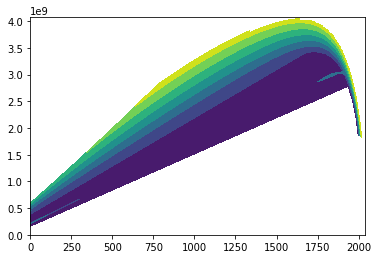

In [31]:
skip_filter = lambda z: z[range(0, arhoM.shape[0], 2),:][:, range(0, arhoM.shape[1], 2)]
plt.contourf(skip_filter(arhoM), skip_filter(e), skip_filter(out))
plt.xlim(left=0)
plt.ylim(bottom=0)

In [56]:
# Quick u(p,t) and rho(p,t) to skip the underlying XSteam iteration in region 3
# p = np.linspace(0.01, 100, 10)
# T = np.linspace(274, 2000, 7)
# mg_p, mg_T = np.meshgrid(p,T)
# u_tab = np.zeros_like(mg_p)

# for i in range(len(p)):
#   for j in range(len(T)):
#     u_tab[i,j] = itab.steam_table.u_pt(mg_p[i,j],mg_T[i,j])

from scipy.spatial import KDTree

# pT tree
scaling_pT_space = np.array([1,0.1])
# Build tree
kdt = KDTree(np.vstack((itab.rd_tab["p"].ravel()*scaling_pT_space[0],
  itab.rd_tab["t_ph"].ravel()*scaling_pT_space[1])).T)
# Get nearest index from scaled L2 norm
get_index = lambda qpoints: kdt.query(
  np.array(qpoints)*scaling_pT_space, k=1)[1]
uravel = itab.rd_tab["u_ph"].ravel()
rhoravel = itab.rd_tab["rho_ph"].ravel()
u_est = lambda qpoints: uravel[get_index(qpoints)]
rho_est = lambda qpoints: rhoravel[get_index(qpoints)]

# Performance testing
qpoints = (22, 280)
num_runs = 1000
t1 = perf_counter()
for i in range(num_runs):
  # Quick estimator
  (u_est(qpoints), rho_est(qpoints))
t2 = perf_counter()
for i in range(num_runs):
  # Table lookup
  (itab.steam_table.u_pt(*qpoints), (itab.steam_table.rho_pt(*qpoints)))
t3 = perf_counter()

print(f"KDTnearest: {(t2 - t1)/num_runs}")
print(f"Steamtable: {(t3 - t2)/num_runs}")

(u_est(qpoints), rho_est(qpoints)), (itab.steam_table.u_pt(*qpoints), (itab.steam_table.rho_pt(*qpoints)))

KDTnearest: 6.284949999917444e-05
Steamtable: 4.4938800000636546e-05


((128.01733024343568, 1004.8716474618606),
 (28.45618842613658, 1010.3087362936246))

In [325]:
p_try = p_test_vec[35]
T_est = (e_test - arhoW * (e_water_crit - cv_water_nominal * itab.T_crit)) \
  / (arhoM_test * c_m + arhoW * cv_water_nominal)
# Refine temperature estimate at fixed pressure by fixed point iteration
fpi_T = lambda T: (e_test - arhoW * 1e3*itab.steam_table.u_pt(p_try, T)) \
  / (arhoM_test * c_m)
T = T_est
for i in range(10):
  T_est = T
  T = fpi_T(T)
  if np.abs(T-T_est) < 1e-3:
    break


In [326]:
1 - (arhoM_test * c_m * T + arhoW * 1e3*itab.steam_table.u_pt(p_try, T))/e_test

-7.320712391845063e-08

In [213]:
griddata((itab.rd_tab["rho_ph"].ravel(),
  itab.rd_tab["h"].ravel()), itab.rd_tab["p"].ravel(), (1/v_w, h_est), method="nearest")

83.14798651023071

In [15]:
lambda qpoints : kdt.query(qpoints, k=1)


array(28.36953068)

In [16]:
from scipy.interpolate import griddata
nearest_delaunay = lambda qpoints: griddata((x.ravel(), y.ravel()), z.ravel(), qpoints)

array(28.36953068)